In [1]:
import pickle
import numpy as np
import pandas as pd

from geopy.distance import great_circle

import pygmo as pg

In [2]:
case = "Nepal"

# Load Pareto Front Perfect Information

In [3]:
# # Store data (serialize)
# with open('{}/MOO/rob_nondom_pols_test1.pickle'.format(case),
#           'wb') as handle:
#     pickle.dump(
#         (rob_nondom_pols),
#         handle,
#         protocol=pickle.HIGHEST_PROTOCOL)
    
with open('{}/MOO/rob_nondom_pols_test3_norobustnessfilter.pickle'.format(case),
          'rb') as handle:
    Full_Info_nondom_pols = pickle.load(
        handle)

In [4]:
Full_Info_nondom_pols.shape

(72,)

In [5]:
FullInf_FLs = np.array([[int(key[3:]) for key,value in pol.items() if value == 1] for pol in Full_Info_nondom_pols])

In [6]:
FullInf_FLs.shape

(72, 4)

# Load Policies proposed by MPMORDM

In [7]:
output_folder = "MPMORDM Results v1 2015"

In [8]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [9]:
p4_labels = global_label_tree['p4']

In [10]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [11]:
p4_pols = np.array(p4_pols)

In [12]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format((p4_pols.shape)))

P4 after Multi-Period Robust Optimisation contains (1376,) number of policies


In [13]:
p4_FLs = np.array([[int(key[3:]) for key,value in pol.items() if value == 1] for pol in p4_pols])

In [14]:
p4_FLs.shape

(1376, 4)

In [15]:
# In total there are this many unique policies
len(np.unique(p4_FLs, axis=0))

207

# Codification 

## Codify y

In [16]:
mask_mpmordm_in_PF = [True if pol_fls.tolist() in FullInf_FLs.tolist() else False for pol_fls in p4_FLs]

In [17]:
Data = pd.DataFrame(mask_mpmordm_in_PF, columns=['InPF_bool'], index=global_label_tree['p4'])

In [18]:
# Print Some info
p4_FLs_inPF = p4_FLs[mask_mpmordm_in_PF]

p4_FLs_inPF.shape

print(
    "From all {} possible decision paths (MPMORDM), {} are inside the pareto optimal front for the actual values".
    format(p4_FLs.shape[0], p4_FLs[mask_mpmordm_in_PF].shape[0]))

Perc_Opt_Dec_Paths = (p4_FLs[mask_mpmordm_in_PF].shape[0] / p4_FLs.shape[0])*100

print("{0:.1f}% of all decision paths (MPMORDM) are in the Pareto Front".format(Perc_Opt_Dec_Paths))

From all 1376 possible decision paths (MPMORDM), 692 are inside the pareto optimal front for the actual values
50.3% of all decision paths (MPMORDM) are in the Pareto Front


In [19]:
Data.tail()

,InPF_bool
p0n0p1n7p2n52p3n320p4n1692,False
p0n0p1n7p2n52p3n320p4n1693,False
p0n0p1n7p2n52p3n320p4n1694,False
p0n0p1n7p2n52p3n320p4n1695,False
p0n0p1n7p2n52p3n320p4n1696,True


## Get X data

In [20]:
# Helper functions From other Notebooks
"""From: Final Analysis 2 - Hypervolume for each mordmbranch vs uncertainty - Not Cleaned"""
def find_fl_placement_sequence(label):
    """Verificated"""
    max_ps = label.count("p")-1
    sequence = []
    cur_label = label
    while len(sequence) < max_ps:
        last_fl, prev_label = find_last_fl(cur_label)
        sequence.append(last_fl)
        cur_label = prev_label
    return list(reversed(sequence))

def find_last_fl(label):
    prev_label = find_previous_label(label)
    prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, prev_label), index_col=0)
    cur_pol = global_policy_tree[label]
    cur_fls = policy_to_fls(cur_pol)
    for fl in cur_fls:
        if fl in prev_perf.index:
            return fl, prev_label
    raise ValueError("Something went wrong")

def find_previous_label(label):
    for i,l in enumerate(label[::-1]):
        if l == "p":
            return label[:-i-1]
        
def policy_to_fls(pol):
    return [int(key[3:]) for key, val in pol.items() if val == 1]

In [21]:
global_label_tree['p4'][-1]

'p0n0p1n7p2n52p3n320p4n1696'

In [27]:
# test_fl_sequence = find_fl_placement_sequence('p0n0p1n7p2n52p3n320p4n1696')

In [28]:
# test_label_sequence = find_previous_labels('p0n0p1n7p2n52p3n320p4n1696')

In [29]:
def find_previous_labels(label):
    labels = []
    last_label = label
    while True:
        labels.append(last_label)
        last_label = find_previous_label(last_label)
        if len(last_label) == 0:
            return labels
        

In [31]:
# list(zip(test_fl_sequence,reversed(test_label_sequence)))

In [34]:
# test = Data.iloc[0]

In [35]:
# test.name

In [36]:
def get_performance_all_p (label):
    tmp_fl_sequence = find_fl_placement_sequence(label)
    tmp_label_sequence = find_previous_labels(label)
    all_period_perf = pd.DataFrame()
    for fl, lab in zip(tmp_fl_sequence,reversed(tmp_label_sequence)):
#         print('fl',fl,'lab',lab)
        tmp_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, lab), index_col=0).loc[fl]
        all_period_perf = pd.concat([all_period_perf, tmp_perf])
    
    
    all_period_perf = all_period_perf.T
#     all_period_perf.columns = 
    return all_period_perf.values[0]
        
    

In [37]:
get_performance_all_p("p0n0p1n1p2n8p3n53p4n323")

array([7.29270615e+04, 2.90000000e+01, 3.29655900e+04, 9.16519500e+04,
       6.84130459e+04, 2.80000000e+01, 3.26353265e+04, 6.75992170e+04,
       2.83650217e+05, 1.40000000e+01, 8.61744550e+03, 5.85409368e+04,
       2.75848344e+05, 1.30000000e+01, 9.38007728e+03, 3.87554950e+04])

In [38]:
test1 = Data.apply(lambda row: get_performance_all_p(row.name), axis=1)

In [39]:
test2 = np.vstack(test1.values)

In [40]:
test3 = pd.DataFrame(test2)

In [41]:
test3.columns = ['total_costs_p1', 'nr_uncovered_DPs_p1', 'total_uncovered_demand_p1',
       'max_distr_time_p1', 'total_costs_p2', 'nr_uncovered_DPs_p2',
       'total_uncovered_demand_p2', 'max_distr_time_p2', 'total_costs_p3',
       'nr_uncovered_DPs_p3', 'total_uncovered_demand_p3', 'max_distr_time_p3',
       'total_costs_p4', 'nr_uncovered_DPs_p4', 'total_uncovered_demand_p4',
       'max_distr_time_p4']

In [42]:
test3.index = Data.index

In [43]:
Data2 = pd.merge(Data, test3, left_index=True, right_index=True)

# Heuristics Analysis

In [20]:
# import prim

In [44]:
x = Data2.iloc[:,1:]
y = Data2.iloc[:,0]

x = x.to_records()
y = y.values

In [270]:
import matplotlib.pyplot as plt

In [45]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)



C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [46]:
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)


In [47]:
box1 = prim_alg.find_box()

[MainProcess/INFO] 1376 points remaining, containing 692 cases of interest
C:\Users\timro\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
[MainProcess/INFO] mean: 1.0, mass: 0.502906976744186, coverage: 1.0, density: 1.0 restricted_dimensions: 1


In [48]:
# Store data (serialize)
with open('testprimbox.pickle',
          'wb') as handle:
    pickle.dump(
        (prim_alg, box1),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
import matplotlib.pyplot as plt

In [54]:
%matplotlib inline

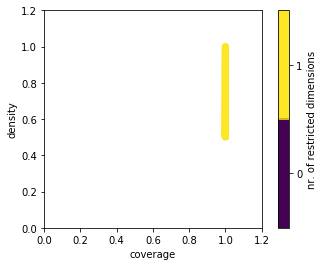

In [55]:
box1.show_tradeoff()
plt.show()

## Classification and Regression Tree

In [56]:
x = Data2.iloc[:,1:]
y = Data2.iloc[:,0]

In [57]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
crossvalidation = KFold(n=x.shape[0], n_folds=5, shuffle=True, random_state=1)

C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\timro\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [60]:
from sklearn import tree
for depth in range(1,10):
    tree_classifier = tree.DecisionTreeClassifier(
        max_depth=depth, random_state=0)
    if tree_classifier.fit(x,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_classifier, x, y,
                                    scoring='accuracy', cv=crossvalidation, n_jobs=1))
    print ('Depth: %i Accuracy: %.3f' % (depth,score))

Depth: 1 Accuracy: 0.500
Depth: 2 Accuracy: 0.543
Depth: 3 Accuracy: 0.582
Depth: 4 Accuracy: 0.622
Depth: 5 Accuracy: 0.655
Depth: 6 Accuracy: 0.679
Depth: 7 Accuracy: 0.693
Depth: 8 Accuracy: 0.737
Depth: 9 Accuracy: 0.741
